This is a slightly improved version of "[Enefit PEBOP: EDA (Plotly) and Modelling](https://www.kaggle.com/code/siddhvr/enefit-pebop-eda-plotly-and-modelling?scriptVersionId=158742203)" notebook, namely 3-rd version that scores best on public LB. List of changes:
- Trained models are now loaded from an external [dataset](https://www.kaggle.com/datasets/kononenko/v2-enefit-pebop-eda-plotly-and-modelling/data), instead of a notebook. This fixes issues in the case a new notebook version is created;
- Ensemble weights are tuned to maximize LB score.

If you find this notebook useful, please appreciate the original work by @siddhvr.

In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.1-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.4.0-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.1.2-cp39-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import math
import ctypes
import random
import matplotlib.pyplot as plt

import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets

import os
import gc
import pickle
import datetime
import optuna

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import joblib
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
from joblib import load

import holidays

In [3]:
# stacking average model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from catboost import Pool
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV

In [4]:
def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
clean_memory()

> <h4> This is a bonus version of this Notebook, since I have exhausted my entire GPU quota for the week 🙃. 
Here, I have tried to ensemble the predictions of two trained models. But the catch is that both were trained on datasets having different number of features. I have tried to explore the implications of this difference on the end predictions. 

> <h4> I will be using a trained model which I published earlier as a dataset. It had an independent MAE of 65.51 on the public test set (LeaderBoard) and the other model will be the one which we trained on Version 1[(see here)](https://www.kaggle.com/code/siddhvr/enefit-pebop-eda-plotly-and-modelling) of this notebook.

### Step 1 : Create a class to access and process all the data files

In [5]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test


### Step 2: Create Feature Enegineering Classes

> <h4> For ease of understanding and clarity, I will be using two different feature engineering classes for both models. However, we can also merge them and make a single class since, most of the functions are the same with minor changes elsewhere. But remember to have two different <i>'generate_features'</i> functions for both of these in that case.

In [6]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(pl.concat_str("county","is_business","product_type","is_consumption",separator="_",).alias("segment"),)
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),(np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),(np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _client_features(self, df_features):
        df_client = self.data.df_client

        df_features = df_features.join(
            df_client.with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),on=["county", "is_business", "product_type", "date"],how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _forecast_weather_features(self, df_features):
        df_forecast_weather = self.data.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
#             .drop("hours_ahead")
            .with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),)
            .join(df_weather_station_to_county_mapping,how="left",on=["longitude", "latitude"],).drop("longitude", "latitude"))

        df_forecast_weather_date = (df_forecast_weather.group_by("datetime").mean().drop("county"))

        df_forecast_weather_local = (df_forecast_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean())

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on="datetime",how="left",suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on=["county", "datetime"],how="left",suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _historical_weather_features(self, df_features):
        df_historical_weather = self.data.df_historical_weather
        df_weather_station_to_county_mapping = (self.data.df_weather_station_to_county_mapping)

        df_historical_weather = (
            df_historical_weather.with_columns(pl.col("latitude").cast(pl.datatypes.Float32),pl.col("longitude").cast(pl.datatypes.Float32),
            ).join(df_weather_station_to_county_mapping,how="left",on=["longitude", "latitude"],).drop("longitude", "latitude")
        )

        df_historical_weather_date = (df_historical_weather.group_by("datetime").mean().drop("county"))

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null()).group_by("county", "datetime").mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on="datetime",how="left",suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),on=["county", "datetime"],how="left",suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),).filter(pl.col("hour") <= 10).drop("hour"),on="datetime",how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _target_features(self, df_features):
        df_target = self.data.df_target

        df_target_all_type_sum = (df_target.group_by(["datetime", "county", "is_business", "is_consumption"]).sum().drop("product_type"))

        df_target_all_county_type_sum = (df_target.group_by(["datetime", "is_business", "is_consumption"]).sum().drop("product_type", "county"))
        
        hours_list=[i*24 for i in range(2,15)]

        for hours_lag in hours_list:
            df_features = df_features.join(
                df_target.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(pl.col("datetime") + pl.duration(hours=hours_lag)).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [f"target_{hours_lag}h" for hours_lag in hours_list[:4]]
        
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats).transpose().std().transpose().to_series().alias(f"target_std"),
            )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),("target", 24 * 2, 24 * 9),("target", 24 * 3, 24 * 10),("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (pl.col(f"{target_prefix}_{lag_nominator}h")/ (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )
        
        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop("datetime", "hour", "dayofyear")
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = ["county","is_business","product_type","is_consumption","segment",]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features
    
    # added some new features here
    def _additional_features(self,df):
        for col in [
                    'temperature', 
                    'dewpoint', 
                    '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 
            ]:
            for window in [1]:
                df[f"{col}_diff_{window}"] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)
        return df
    
    def _log_outliers(self,df):
        l1=['installed_capacity', 'target_mean', 'target_std']
        for i in l1:
            df = df.with_columns([(f"log_{i}", pl.when(df[i] != 0).then(np.log(pl.col(i))).otherwise(0))])
        return df
        

    def generate_features(self, df_prediction_items,isTrain):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._general_features,self._client_features,self._forecast_weather_features,
            self._historical_weather_features,self._target_features,self._holidays_features,
            self._log_outliers,self._reduce_memory_usage,self._drop_columns,]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)
        df_features = self._additional_features(df_features)

        return df_features


In [7]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [2 * 24,3 * 24,4 * 24,5 * 24,6 * 24,7 * 24,8 * 24,9 * 24,10 * 24,11 * 24,12 * 24,13 * 24,14 * 24,]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features
    
    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

**Featureweather**

In [8]:
class FeatureWeather:
    def __init__(self, data_weather):
        self.data_storage = data_weather
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features
        
    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
        for hours_lag in [0, 2 * 24, 3 * 24, 7 * 24]:    
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )  

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features      
    
    
    def _add_weather_difference_features(self, df_features):
        weather_diff_cols = ['direct_solar_radiation', 'surface_solar_radiation_downwards','temperature','dewpoint']
        for hours_lag in [2 * 24, 3 * 24, 7 * 24]:
            for col in weather_diff_cols:
                df_features = df_features.with_columns(
                   (pl.col(f'{col}_forecast_local_0h') -  pl.col(f'{col}_forecast_local_{hours_lag}h')).alias(f'{col}_forecast_l_diff_{hours_lag}h'),
                )
                
        for forecast_prefix, lag_nominator, lag_denomonator in [
            ('direct_solar_radiation', 24 * 2, 24 * 3),
            ('direct_solar_radiation', 24 * 2, 24 * 7),
            ('direct_solar_radiation', 24 * 3, 24 * 7),
            ('surface_solar_radiation_downwards', 24 * 2, 24 * 3),
            ('surface_solar_radiation_downwards', 24 * 2, 24 * 7),
            ('surface_solar_radiation_downwards', 24 * 3, 24 * 7),
            ('temperature', 24 * 2, 24 * 3),
            ('temperature', 24 * 2, 24 * 7),
            ('temperature', 24 * 3, 24 * 7),
            ('dewpoint', 24 * 2, 24 * 3),
            ('dewpoint', 24 * 2, 24 * 7),
            ('dewpoint', 24 * 3, 24 * 7),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{forecast_prefix}_forecast_local_{lag_nominator}h")
                    / (pl.col(f"{forecast_prefix}_forecast_local_{lag_denomonator}h") + 1e-3)
                ).alias(f"{forecast_prefix}_forecast_l_ratio_{lag_nominator}_{lag_denomonator}")
            )  
            
        return df_features  
            
            
    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats).transpose().std().transpose().to_series().alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )
        
        df_features = df_features.with_columns(
               (pl.col('target_48h')/pl.col('installed_capacity')).alias('target_48h_installed')
        )
        df_features = df_features.with_columns(
               (pl.col('target_72h')/pl.col('installed_capacity')).alias('target_72h_installed')
        )
        df_features = df_features.with_columns(
               (pl.col('target_96h')/pl.col('installed_capacity')).alias('target_96h_installed')
        )
        
        df_features = df_features.with_columns(
               ((pl.col('eic_count') - pl.col('eic_count').mean())/ pl.col('eic_count').mean() * 100).alias('normalized_eic_count')
        ) 
        df_features = df_features.with_columns(
               ((pl.col('installed_capacity') - pl.col('installed_capacity').mean())/ pl.col('installed_capacity').mean() * 100).alias('normalized_installed_capacity')
        )    

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_weather_difference_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

# Initialisation

In [9]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)
feat_gen = FeatureEngineer(data=data_storage)
feat_weather = FeatureWeather(data_weather=data_storage)

### Feature Generation

> <h5>Although there is no requirement as such to create the training datasets, (since we are not doing any model training here) I have created them only to show the difference in the features between the two datasets we are using here

In [10]:
df_train_weather = feat_weather.generate_features(data_storage.df_data)
df_train_weather = df_train_weather[df_train_weather['target'].notnull()]

In [11]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

In [12]:
df_train = feat_gen.generate_features(data_storage.df_data,True)
df_train = df_train[df_train['target'].notnull()]

In [13]:
df_train_features.shape

(1651902, 166)

In [14]:
df_train.shape

(1651902, 176)

In [15]:
df_train_weather.shape

(1651902, 219)

In [16]:
gc.collect()

0

In [17]:
for col in df_train.columns:
    if (col not in df_train_features.columns):
        print(col)

date
hours_ahead
hours_ahead_forecast_local_0h
hours_ahead_forecast_168h
hours_ahead_forecast_local_168h
literal
temperature_diff_1
dewpoint_diff_1
10_metre_u_wind_component_diff_1
10_metre_v_wind_component_diff_1


In [18]:
if('date' in df_train_features.columns):
    df_train_features.drop(columns=['date'], inplace=True)

# DeepTables 

Learning rate schedule: 1e-07 to 0.001 to 1e-07


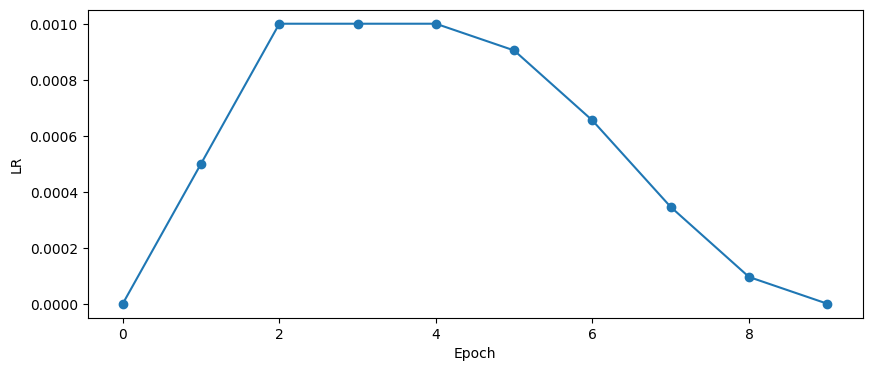

In [19]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
        
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [20]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params_production = {
            "n_estimators": 2500,
            "learning_rate": 0.052587652,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "cpu",
        }
        self.lgb_params_consumption = {
            "n_estimators": 3000,
            "learning_rate": 0.072314526,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 24,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "cpu",
        }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params_consumption)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params_production)
        
        #self.lgb_model_consumption = VotingRegressor(
        #    [
        #        (
        #            f"consumption_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_consumption, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        #self.lgb_model_production = VotingRegressor(
        #    [
        #        (
        #            f"production_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_production, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        
    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model = Model()
model.fit(df_train_weather)
clean_memory()

nn = True
lgb = True

 nn model consumption training. 

01-30 00:16:36 I deeptables.m.deeptable.py 338 - X.Shape=(825951, 218), y.Shape=(825951,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7e40b3ff0280>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-30 00:16:38 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 00:16:40 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 00:16:43 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.836514949798584s
01-30 00:16:43 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 00:16:52 I deeptables.m.preprocessor.py 383 - Imputation taken 8.935818195343018s
01-30 00:16:52 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 00:16:52 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.2370901107788086s
01-30 00:16:52 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 00:16:52 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 00:17:04 I deeptables.m.preprocessor.py 404 - Discretization taken 12.422903776168823s
01-30 00:17:09 I deeptables.m.preprocessor.py 196 - fit_transform taken 30.38438057899475s
01-30 00:17:09 I deeptables.m.deeptable.py 354 - Training...
01-30 00:17:09 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_m,

01-30 00:35:31 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 00:35:32 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 00:35:34 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.384514570236206s
01-30 00:35:34 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 00:35:43 I deeptables.m.preprocessor.py 383 - Imputation taken 8.859158277511597s
01-30 00:35:43 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 00:35:43 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.23823928833007812s
01-30 00:35:43 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 00:35:43 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 00:35:54 I deeptables.m.preprocessor.py 404 - Discretization taken 10.780705213546753s
01-30 00:35:58 I deeptables.m.preprocessor.py 196 - fit_transform taken 26.412356853485107s
01-30 00:35:58 I deeptables.m.deeptable.py 354 - Training...
01-30 00:36:01 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPan

In [21]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model_0:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params_production = {
            "n_estimators": 4816,
            "learning_rate": 0.05762004005019972,
            "colsample_bytree": 0.5329267289068419,
            "colsample_bynode": 0.8190524860421544,
            "lambda_l1": 6.826342308358434,
            "lambda_l2": 9.896390141984359,
            "max_depth": 10,
            "min_data_in_leaf": 12,
            'max_bin': 836,
            "objective": "regression_l1",
            "device": "cpu",
        }
        
        self.lgb_params_consumption = {
            "n_estimators": 4468,
            "learning_rate": 0.051587155894154094,
            "colsample_bytree": 0.5744556598680428,
            "colsample_bynode": 0.8156506256005505,
            "lambda_l1": 1.6751103987805591,
            "lambda_l2": 5.13700667827768,
            "max_depth": 9,
            "min_data_in_leaf": 173,
            'max_bin': 151,
            "objective": "regression_l1",
            "device": "cpu",
        }
        
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params_consumption)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params_production)
        
        #self.lgb_model_consumption = VotingRegressor(
        #    [
        #        (
        #            f"consumption_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_consumption, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        #self.lgb_model_production = VotingRegressor(
        #    [
        #        (
        #            f"production_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_production, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        
    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = (df_train_features["is_business"] == 0) & (df_train_features['is_consumption'] == 1)
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = (df_train_features["is_business"] == 0) & (df_train_features['is_consumption'] == 0)
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = (df_train_features["is_business"] == 0) & (df_train_features['is_consumption'] == 1)
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = (df_train_features["is_business"] == 0) & (df_train_features['is_consumption'] == 0)
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = (df_features["is_business"] == 0) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model_0 = Model_0()
model_0.fit(df_train_weather)
clean_memory()

nn = True
lgb = True

 nn model consumption training. 

01-30 02:38:47 I deeptables.m.deeptable.py 338 - X.Shape=(378028, 218), y.Shape=(378028,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7e3d9183fe80>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-30 02:38:48 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 02:38:49 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 02:38:50 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.5175926685333252s
01-30 02:38:50 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 02:38:55 I deeptables.m.preprocessor.py 383 - Imputation taken 4.967902183532715s
01-30 02:38:55 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 02:38:55 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.091522216796875s
01-30 02:38:55 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 02:38:55 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 02:39:02 I deeptables.m.preprocessor.py 404 - Discretization taken 6.5470335483551025s
01-30 02:39:04 I deeptables.m.preprocessor.py 196 - fit_transform taken 15.41740894317627s
01-30 02:39:04 I deeptables.m.deeptable.py 354 - Training...
01-30 02:39:04 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_m,

01-30 02:47:22 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 02:47:22 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 02:47:23 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.225921869277954s
01-30 02:47:23 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 02:47:27 I deeptables.m.preprocessor.py 383 - Imputation taken 3.8120369911193848s
01-30 02:47:27 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 02:47:27 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.08145380020141602s
01-30 02:47:27 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 02:47:27 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 02:47:33 I deeptables.m.preprocessor.py 404 - Discretization taken 6.066195249557495s
01-30 02:47:36 I deeptables.m.preprocessor.py 196 - fit_transform taken 13.65820598602295s
01-30 02:47:36 I deeptables.m.deeptable.py 354 - Training...
01-30 02:47:37 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPand

In [22]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model_1:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params_production = {
            "n_estimators": 3906,
            "learning_rate": 0.08313616746400578,
            "colsample_bytree": 0.9091800966076276,
            "colsample_bynode": 0.662635011373687,
            "lambda_l1": 8.315655499927392,
            "lambda_l2": 8.349555455794054,
            "max_depth": 10,
            "min_data_in_leaf": 150,
            'max_bin': 819,
            "objective": "regression_l1",
            "device": "cpu",
        }
        
        self.lgb_params_consumption = {
            "n_estimators": 3183,
            "learning_rate": 0.03536956293355251,
            "colsample_bytree": 0.5729074917490897,
            "colsample_bynode": 0.8596519737421342,
            "lambda_l1": 7.316399785964528,
            "lambda_l2": 9.952037457652327,
            "max_depth": 9,
            "min_data_in_leaf": 218,
            'max_bin': 51,
            "objective": "regression_l1",
            "device": "cpu",
        }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params_consumption)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params_production)
        
        #self.lgb_model_consumption = VotingRegressor(
        #    [
        #        (
        #            f"consumption_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_consumption, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        #self.lgb_model_production = VotingRegressor(
        #    [
        #        (
        #            f"production_lgb_{i}",
        #            lgb.LGBMRegressor(**self.lgb_params_production, random_state=i),
        #        )
        #        for i in range(3)
        #    ]
        #)
        
    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = (df_train_features["is_business"] == 1) & (df_train_features['is_consumption'] == 1)
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = (df_train_features["is_business"] == 1) & (df_train_features['is_consumption'] == 0)
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = (df_train_features["is_business"] == 1) & (df_train_features['is_consumption'] == 1)
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = (df_train_features["is_business"] == 1) & (df_train_features['is_consumption'] == 0)
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 1)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = (df_features["is_business"] == 1) & (df_features['is_consumption'] == 0)
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model_1 = Model_1()
model_1.fit(df_train_weather)
clean_memory()

nn = True
lgb = True

 nn model consumption training. 

01-30 03:17:59 I deeptables.m.deeptable.py 338 - X.Shape=(447923, 218), y.Shape=(447923,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7e40de3f02b0>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-30 03:18:00 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 03:18:01 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 03:18:02 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.6579830646514893s
01-30 03:18:02 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 03:18:07 I deeptables.m.preprocessor.py 383 - Imputation taken 4.593993186950684s
01-30 03:18:07 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 03:18:07 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.10190010070800781s
01-30 03:18:07 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 03:18:07 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 03:18:15 I deeptables.m.preprocessor.py 404 - Discretization taken 7.5214338302612305s
01-30 03:18:17 I deeptables.m.preprocessor.py 196 - fit_transform taken 16.891738176345825s
01-30 03:18:17 I deeptables.m.deeptable.py 354 - Training...
01-30 03:18:17 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val

01-30 03:28:30 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-30 03:28:30 I deeptables.m.preprocessor.py 261 - Preparing features...
01-30 03:28:32 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.491227149963379s
01-30 03:28:32 I deeptables.m.preprocessor.py 341 - Data imputation...
01-30 03:28:37 I deeptables.m.preprocessor.py 383 - Imputation taken 4.6638572216033936s
01-30 03:28:37 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-30 03:28:37 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.0992588996887207s
01-30 03:28:37 I deeptables.m.preprocessor.py 398 - Data discretization...
01-30 03:28:37 I hypernets.t.sklearn_ex.py 716 - 212 variables to discrete.
01-30 03:28:44 I deeptables.m.preprocessor.py 404 - Discretization taken 6.921899318695068s
01-30 03:28:46 I deeptables.m.preprocessor.py 196 - fit_transform taken 15.796026468276978s
01-30 03:28:46 I deeptables.m.deeptable.py 354 - Training...
01-30 03:28:47 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPand

# Loading Trained Models

In [23]:
c1 = load('/kaggle/input/enefit-trained-model/voting_regressor_consumption_model.joblib')
p1 = load('/kaggle/input/enefit-trained-model/voting_regressor_production_model.joblib')
gc.collect()

0

In [24]:
dc1 = load('/kaggle/input/v2-enefit-pebop-eda-plotly-and-modelling/voting_regressor_consumption_model.joblib')
dp1 = load('/kaggle/input/v2-enefit-pebop-eda-plotly-and-modelling/voting_regressor_production_model.joblib')
gc.collect()

0

## Declaring separate prediction functions for both models

In [25]:
def predict(df_features,model_consumption=c1,model_production=p1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = model_consumption.predict(
            df_features[mask]
    ).clip(0)

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = model_production.predict(
            df_features[mask]
    ).clip(0)

    return predictions

In [26]:
def predict_model(df_features,hours_lag=48,model_consumption=dc1,model_production=dp1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_consumption.predict(df_features[mask]),0,np.inf,
        )

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_production.predict(df_features[mask]),0,np.inf,
        )

    return predictions


In [27]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [28]:
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_features = features_generator.generate_features(df_test)
    
    df_test_feats = feat_gen.generate_features(df_test,False)
    
    df_test_feats.drop(columns=['date','literal'],inplace=True)
    
    df_test_weather = feat_weather.generate_features(df_test)
    
    df_test_weather['installed_capacity'] = df_test_weather['installed_capacity'].fillna(1000)
    
    pred1 = predict(df_test_features) # lgbm(votingregression) Version1
    
    pred2 = predict_model(df_test_feats) # lgbm(votingregression) Version2 
    
    pred3 = model.predict(df_test_weather)
      
    pred_0 = model_0.predict(df_test_weather)
    
    pred_1 = model_1.predict(df_test_weather)
    
    pred4 = (pred_0 + pred_1)
 
    # Ensembling with slightly tuned model weights
    df_sample_prediction["target"] = (
        (0.25 * pred1) + 
        (0.3 * pred2) +
        (0.3 * pred3) +
        (0.15 * pred4)
    )
    
    env.predict(df_sample_prediction)
    gc.collect()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.

 nn & lgb model consumption prediction. 

01-30 04:06:38 I deeptables.m.deeptable.py 685 - Perform prediction...
01-30 04:06:38 I deeptables.m.preprocessor.py 242 - Transform [X]...
01-30 04:06:38 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5126051902770996s
01-30 04:06:38 I deeptables.m.deepmodel.py 130 - Performing predictions...
01-30 04:06:38 I deeptables.u.dataset_generator.py 240 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=False, drop_remainder=False
01-30 04:06:40 I deeptables.m.deeptable.py 559 - predict_proba taken 2.0409951210021973s

 nn & lgb model production prediction. 

01-30 04:06:41 I deeptables.m.deeptable.py 685 - Perform prediction...
01-30 04:06:41 I deeptables.m.preprocessor.py 242 - Transform [X]...
01-30 04:06:41 I deeptables.m.preprocessor.py 249 - transform_X taken 0.5094857215881348s
01-30 04:06